# Phase III

Milestone instructions:  
  
Phase III: Preregistration of analyses. Due Nov 2.
- Preregister at least two analyses that you vow to present in your final report, no matter the results (significant or not).
    - Do not perform these analyses, check they are significant, and then “preregister” them. That defeats the purpose. You can learn a lot from associations that are not statistically significant!
        - Keep in mind that for your final report, you must provide at least one model showing patterns or relationships between variables that addresses your research question.
- Submit an executed Jupyter notebook (.ipynb) file on CMS with your preregistration. Include a “Questions for reviewers” section at the end of your submission, listing specific questions for your project mentor to answer in giving you feedback on this phase.

H0 : p1 = p2  
The proportion of _Accipiter_ observations in each habitat type is equal to the proportion of that habitat type across all observations -> _Accipiter_ is observed at equal frequencies across sites with differing housing densities.

HA : p1 != p2  
The proportion of _Accipiter_ observations in each habitat type is not equal to the proportion of that habitat type across all observations -> _Accipiter_ is more frequently observed at sites with certain housing densities.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
#loading SQL
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [3]:
# loading in full dataset
df = pd.DataFrame(pd.read_csv("rolled_up_NY_df.csv"))

In [4]:
df.columns = list(map(str.lower, df.columns)) # making column names case-consistent

# dropping irrelevant columns
df.drop(['unnamed: 0', '...1', 'latitude', 'longitude', 'entry_technique', 'proj_period_id', 'reviewed', 'sub_id', 'obs_id',
        'effort_hrs_atleast', 'data_entry_method'], axis= 1, inplace= True)

# dropping observations that are not valid
df = df[df['valid'] == 1]

In [5]:
# joining a table with common names to the dataset
species_translate_df = pd.DataFrame(pd.read_csv("PFW-species-translation-table.csv"))
%sql df << SELECT loc_id, subnational1_code, month, day, year, df.species_code, how_many, valid, day1_am, day1_pm, day2_am, day2_pm, snow_dep_atleast, scientific_name, american_english_name AS species_name FROM df INNER JOIN species_translate_df ON df.species_code = species_translate_df.species_code;

Returning data to local variable df


In [6]:
# splitting the scientific name into two columns - the genus and species names
df[['genus','species']] = df['scientific_name'].str.split(expand=True).iloc[:, :2]

In [7]:
# looking at observation counts for each genus
df['genus'].value_counts()

Accipiter      984032
Buteo          738024
Larus          738024
Colaptes       738024
Junco          492016
                ...  
Lanius         246008
Sphyrapicus    246008
Bombycilla     246008
Cathartes      246008
Nannopterum    246008
Name: genus, Length: 75, dtype: int64

In [8]:
# selecting Accipiter genus data
accipiter_df = df[df['genus'] == 'Accipiter']

# selecting Junco genus data
junco_df = df[df['genus'] == 'Junco']

In [9]:
# reading in raw provided data
csv_sites = pd.read_csv("PFW_count_site_data_public_2021.csv")

#creating dataframe
sites_df = pd.DataFrame(csv_sites)

# keeping only the columns that will be involved in analysis
sites_df = sites_df[['loc_id', 'housing_density', 'population_atleast']]

In [10]:
#join accipiter and junco dataframes with sites_df (location details)
%sql accipiter_df << SELECT accipiter_df.loc_id, genus, species, how_many, species_name, housing_density, population_atleast FROM accipiter_df INNER JOIN sites_df ON accipiter_df.loc_id = sites_df.loc_id;
%sql junco_df << SELECT junco_df.loc_id, genus, species, how_many, species_name, housing_density, population_atleast FROM junco_df INNER JOIN sites_df ON junco_df.loc_id = sites_df.loc_id;

Returning data to local variable accipiter_df
Returning data to local variable junco_df


In [11]:
accipiter_df

,loc_id,genus,species,how_many,species_name,housing_density,population_atleast
0,L6731705,Accipiter,striatus,0,Sharp-shinned Hawk,3.0,5001.0
1,L6731705,Accipiter,striatus,0,Sharp-shinned Hawk,3.0,5001.0
2,L6731705,Accipiter,striatus,0,Sharp-shinned Hawk,3.0,5001.0
3,L6731705,Accipiter,striatus,0,Sharp-shinned Hawk,3.0,5001.0
4,L6731705,Accipiter,striatus,0,Sharp-shinned Hawk,3.0,5001.0
...,...,...,...,...,...,...,...
5087763,L42375,Accipiter,gentilis,0,Northern Goshawk,3.0,100001.0
5087764,L42375,Accipiter,gentilis,0,Northern Goshawk,3.0,100001.0
5087765,L42375,Accipiter,gentilis,0,Northern Goshawk,3.0,100001.0
5087766,L42375,Accipiter,gentilis,0,Northern Goshawk,3.0,100001.0


In [12]:
junco_df

,loc_id,genus,species,how_many,species_name,housing_density,population_atleast
0,L6731705,Junco,hyemalis,0,Dark-eyed Junco,3.0,5001.0
1,L6731705,Junco,hyemalis,0,Dark-eyed Junco,3.0,5001.0
2,L6731705,Junco,hyemalis,0,Dark-eyed Junco,3.0,5001.0
3,L6731705,Junco,hyemalis,0,Dark-eyed Junco,3.0,5001.0
4,L6731705,Junco,hyemalis,0,Dark-eyed Junco,3.0,5001.0
...,...,...,...,...,...,...,...
2543879,L5054277,Junco,hyemalis,0,Dark-eyed Junco (Slate-colored),3.0,25001.0
2543880,L5054277,Junco,hyemalis,0,Dark-eyed Junco (Slate-colored),3.0,25001.0
2543881,L5054277,Junco,hyemalis,0,Dark-eyed Junco (Slate-colored),3.0,25001.0
2543882,L5054277,Junco,hyemalis,0,Dark-eyed Junco (Slate-colored),3.0,25001.0


[ Text explaining the housing_density variable ]

In [66]:
def plot_proportions_by_housing(df):
    """
    Returns: None. Generates four figures with two subplots each. Each figure represents one housing density category. The first 
    the proportion of counts for that genus that were made in sites with that housing density.
    The second subplot depicts the proportion of the total observations taken up by sites with that housing
    density. **** MAYBE REWORD THIS ****
    
    Also prints a statement for each housing density category stating the difference between the expected 
    and observed proportions.
    
    Parameter df: A dataframe with minimum columns 'how_many' (type int, >= 0) and 'housing_density' (type float, 1.0 to 4.0).
   
    """
    housing_density_freq = df['housing_density'].value_counts() # series with counts for observations with each housing density

    # list of categories mapped to by the floats in housing_density
    housing_density_categories = ["rural", "suburban rural", " suburban", "urban"] 

    # looping through numbers 1-4, the values in housing_density
    for i in range(1, 5): 
    
        # slicing dataframe into observations that were taken in sites with this housing density and observations that were taken otherwise
        out_df = df[df['housing_density'] != float(i)] # outside this housing density
        in_df = df[df['housing_density'] == float(i)] # inside this housing density


        out_sum = out_df['how_many'].sum() # sum all counts for this genus observed outside of sites of this housing density
        in_sum = in_df['how_many'].sum() # sum all counts for this genus observed inside sites of of this housing density

        total_sum = out_sum + in_sum # calculate total sum of observed counts

        out_proportion = out_sum/total_sum # proportion of counts observed outside this housing density
        in_proportion = in_sum/total_sum # proportion of counts observed inside this housing density

        # accessing the number of observations with this housing density and dividing by the total number of observations to normalize
        # aka finding proportion of this housing density relative to total house density data
        housing_proportion = housing_density_freq[float(i)] / df['how_many'].count() 


        # plotting on subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
        fig.subplots_adjust(wspace=0.65)
        plt.suptitle("Proportions for Observed Counts for Housing Density = " + housing_density_categories[i-1] + " in Genus " + df["genus"][0])

        
        # subplot 1: showing proportion of observed counts for this genus that took place inside and outside sites
        # with this housing density
        ax1.bar(housing_density_categories[i-1], in_proportion, label = "Proportion of Total Counts Found in " + housing_density_categories[i-1], color = 'darkseagreen')
        ax1.bar(housing_density_categories[i-1], out_proportion, bottom = in_proportion, label = "Proportion of Total Counts Found Outside of " + housing_density_categories[i-1], color = 'navajowhite')
        ax1.legend(bbox_to_anchor=(0.5,-0.35), loc="lower center")

        # subplot 2: showing proportion of observations with this housing density in comparison to total observations
        ax2.bar(housing_density_categories[i-1], housing_proportion, label = "Proportion of Observations Inside of " + housing_density_categories[i-1], color = 'darkseagreen')
        ax2.bar(housing_density_categories[i-1], 1 - housing_proportion, bottom = housing_proportion, label = "Proportion of Observations Outside of " + housing_density_categories[i-1], color = 'navajowhite')
        ax2.legend(bbox_to_anchor=(0.5,-0.35), loc="lower center")
        plt.show()

        # printing the discrepancy between the two bars in the subplots
        print("Difference between expected and actual observed proportion: " + str(in_proportion - housing_proportion))

### Plotting proportions for genus _Accipiter_

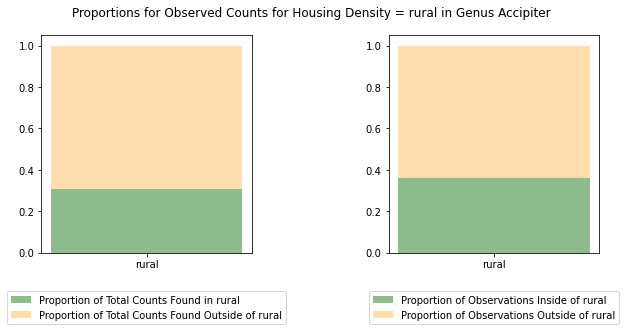

Difference between expected and actual observed proportion: -0.053212522312686306


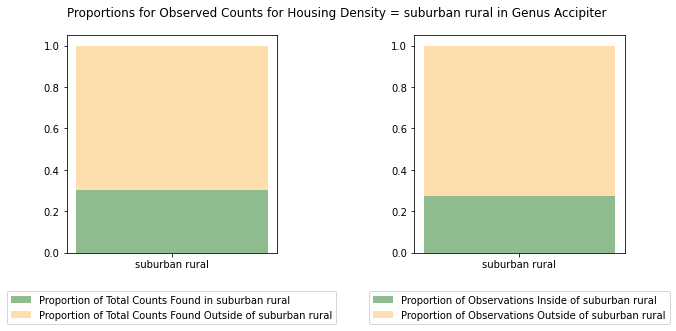

Difference between expected and actual observed proportion: 0.02846123318785071


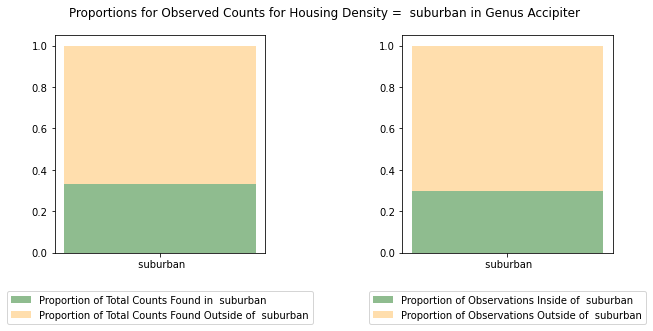

Difference between expected and actual observed proportion: 0.033083007453694135


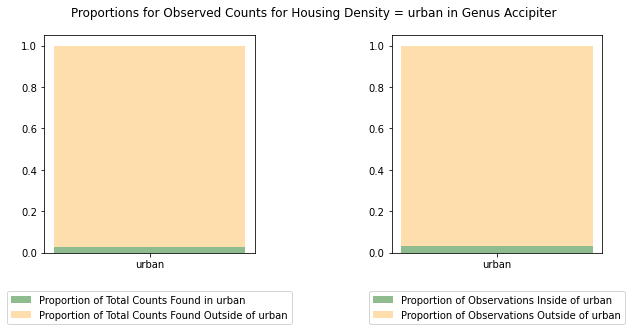

Difference between expected and actual observed proportion: -0.004072242700279449


In [67]:
plot_proportions_by_housing(accipiter_df)

### Plotting proportions for genus _Junco_

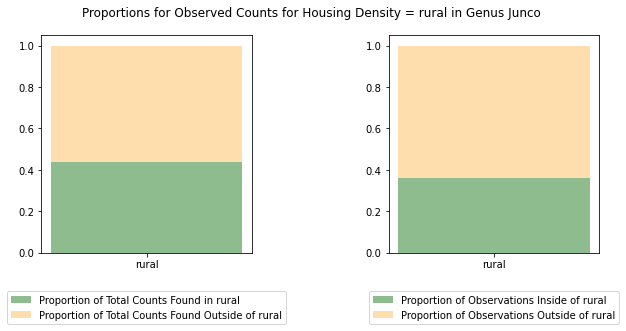

Difference between expected and actual observed proportion: 0.07842060563138492


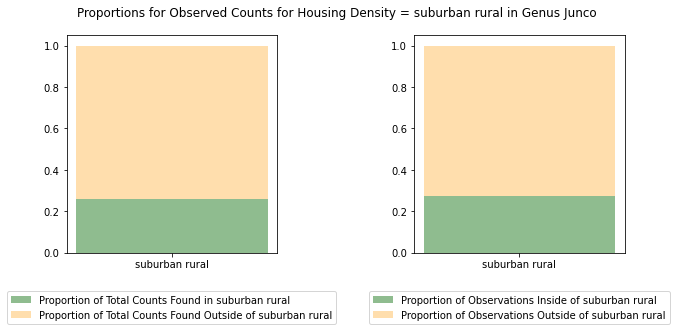

Difference between expected and actual observed proportion: -0.017201447643771683


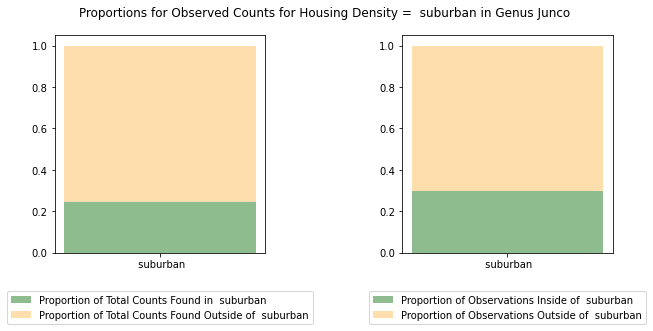

Difference between expected and actual observed proportion: -0.05536930699656081


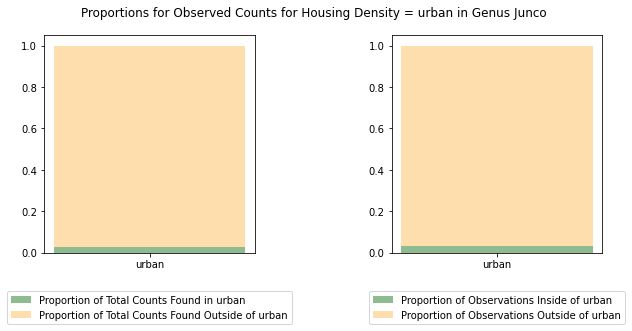

Difference between expected and actual observed proportion: -0.005932706267843094


In [68]:
plot_proportions_by_housing(junco_df)

# Questions for reviewers

- maybe something asking what kind of model / how we should approach making a model for the final project (because regressions might be complicated by zero-filling etc etc)
- asking if it's possible or advisable to do statistical analyses that test for equality between two proportions (idk if all assumptions of those tests are fulfilled by the data here), and if so, what exact test / test statistic we should use